# SIFT 

In this notebook we want to join three images of the same object taken from different perspectives. We will use SIFT method to find the best matches.

In [1]:
import cv2 as cv2
import matplotlib.pyplot as plt
import numpy as np

The images we want to join:

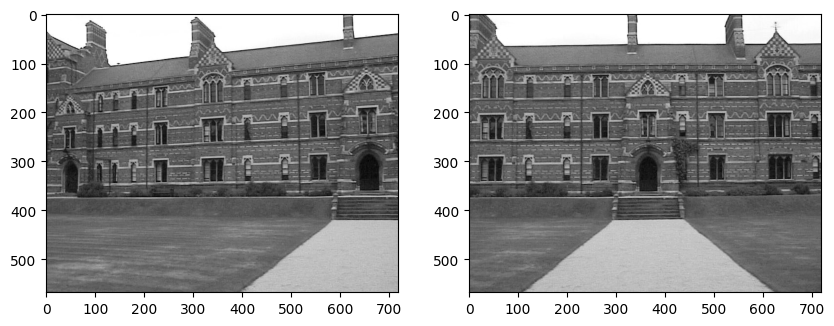

In [4]:
imagem1 = cv2.imread('img/keble_a.jpg')
grey1 = cv2.cvtColor(imagem1, cv2.COLOR_BGR2GRAY)

imagem2 = cv2.imread('img/keble_b.jpg')
grey2 = cv2.cvtColor(imagem2, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(1,2,figsize=(10,10))

ax[0].imshow(grey1, cmap="gray")
ax[1].imshow(grey2, cmap="gray")

We'll simply use the SIFT method from OpenCV and show the image with circles around features:

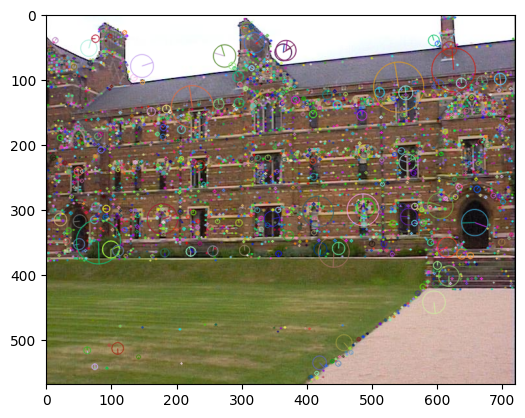

In [22]:
sift = cv2.SIFT_create()

pontos1, descritores1 = sift.detectAndCompute(grey1, None)
pontos2, descritores2 = sift.detectAndCompute(grey2, None)

imagem_com_circulos = cv2.drawKeypoints(imagem1, pontos1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


plt.imshow( cv2.cvtColor(imagem_com_circulos, cv2.COLOR_BGR2RGB))

Just as an exemple, we show a point detected:

In [23]:
ponto_escolhido = pontos1[7]

print(f"""
    Coordenadas (x, y): {ponto_escolhido.pt}
    Escala: {ponto_escolhido.size}
    Ângulo: {ponto_escolhido.angle}
    Reponse: {ponto_escolhido.response}
    Oitava: {ponto_escolhido.octave}
      """)


    Coordenadas (x, y): (3.3213491439819336, 366.48834228515625)
    Escala: 2.9311280250549316
    Ângulo: 62.865562438964844
    Reponse: 0.04712989181280136
    Oitava: 2032639
      


Next, we want to determine the correspondence of the points found:

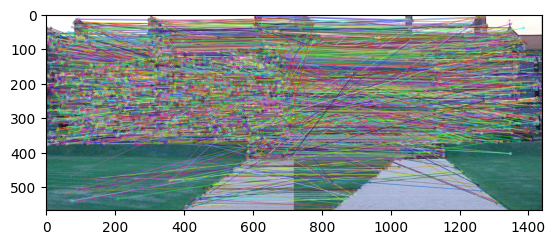

In [24]:
index_params = dict(algorithm=0, trees=5)
search_params = dict()

flann = cv2.FlannBasedMatcher(index_params, search_params)
correspondencias = flann.knnMatch(descritores1, descritores2, k=2)

imagem_correspondencias = cv2.drawMatches(imagem1, pontos1, imagem2, pontos2,
                                           [i[0] for i in correspondencias], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(imagem_correspondencias)

To help, we filter the points:

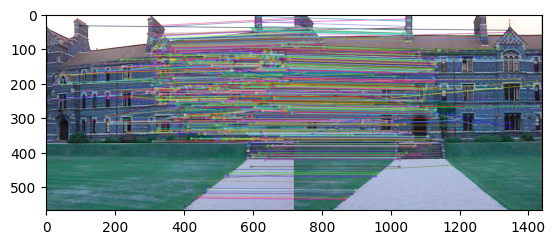

In [25]:
boas_correspondencias = []
for m, n in correspondencias:
    if m.distance < 0.75 * n.distance:
        boas_correspondencias.append(m)

imagem_correspondencias = cv2.drawMatches(imagem1, pontos1, imagem2, pontos2,
                                           boas_correspondencias, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(imagem_correspondencias)

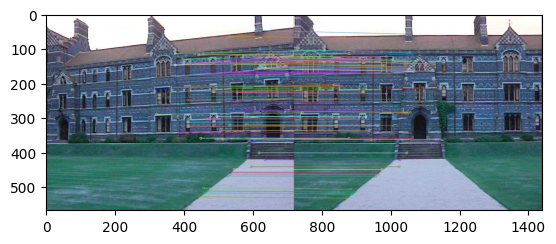

In [26]:
boas_correspondencias = sorted(boas_correspondencias, key=lambda x: x.distance)[:100]

imagem_correspondencias = cv2.drawMatches(imagem1, pontos1, imagem2, pontos2,
                                           boas_correspondencias, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(imagem_correspondencias)

Finally we use the  OpenCV `findHomography` to join the two images:

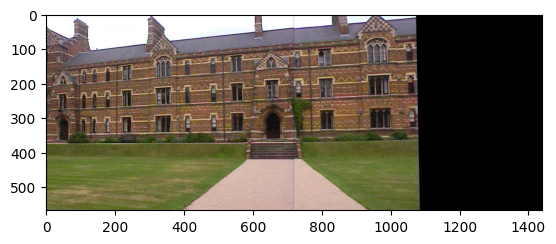

In [27]:
pontos1_np = np.float32([pontos1[m.queryIdx].pt for m in boas_correspondencias]).reshape(-1, 1, 2)
pontos2_np = np.float32([pontos2[m.trainIdx].pt for m in boas_correspondencias]).reshape(-1, 1, 2)

matriz_homografia, mascara = cv2.findHomography(pontos2_np, pontos1_np, cv2.RANSAC, 5.0)

# Unir as imagens usando a matriz de homografia
altura, largura, _ = imagem1.shape
imagem_unida = cv2.warpPerspective(imagem2, matriz_homografia, (largura + imagem2.shape[1], altura))
imagem_unida[0:altura, 0:largura] = imagem1

plt.imshow(cv2.cvtColor(imagem_unida, cv2.COLOR_BGR2RGB))